### **XGBOOST - FUNCTION WRAPPER**

<br>

This is an attempt to take the functionality of both **XGBClassifier** and **XGBRegressor**, and make it easy to iterate over specific datasets with a group of hyperparameters, cross validating and tuning as we go.<br><br>
The model history is stored incrementally as we go, and we can then take the best results achieved with each set of parameters, for visualization, analysis and further tuning if desired.  This is part of some work I'm doing on how the model parameters may be stored in production settings....

In [86]:
from itertools import product
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost.sklearn import XGBClassifier,XGBRegressor

from sklearn.metrics import confusion_matrix,r2_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [212]:
data = pd.read_csv('data_sample.csv')

In [214]:
data

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,0.609551,0.798340,0.530924,0.695092,0.0,0.417013,0.425164,0.173371,0,...,0,0,1,0,0,0,0,0,0,0
1,88.53,0.609551,0.536643,0.530924,0.405698,0.0,0.417013,0.276559,0.173371,0,...,1,0,0,0,0,0,0,0,0,0
2,76.26,0.000000,0.606126,0.000000,0.630973,0.0,0.417013,0.425164,0.268310,0,...,0,0,0,0,0,0,1,0,0,0
3,80.62,0.000000,0.536643,0.000000,0.000000,0.0,0.417013,0.276559,1.000000,0,...,0,0,0,0,0,0,0,0,0,0
4,78.02,0.000000,0.798340,0.000000,0.000000,0.0,0.417013,0.437296,0.681887,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,107.39,0.895580,0.813856,0.605892,0.630973,0.0,0.376506,0.437296,0.722705,0,...,1,0,0,0,0,0,0,0,0,0
4205,108.77,0.883142,0.624909,0.781016,1.000000,0.0,0.376506,0.557023,0.825037,0,...,0,1,0,0,0,0,0,0,0,0
4206,109.22,0.895580,0.798340,0.744581,0.695092,0.0,0.376506,0.367659,1.000000,0,...,0,0,1,0,0,0,0,0,0,0
4207,87.48,0.394160,0.753511,0.437713,0.000000,0.0,0.376506,0.276559,0.563257,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
# define the hyperparameters we want to tune for - we can choose a discrete or continuous scale in some cases
xgb_param_candidates = {
    'epochs': [2000], #[50,100,200,500,1000,2000,5000],
    'depth': [2,3,4,5,6,7,8],
    'eta': [0.01,0.02,0.05,0.1,0.2,0.3,0.5,1],
    'mcw': [2,3,5,10,20]
}

def gen_hypers(params, continuous = None, limit = 150):

    param_db = pd.DataFrame(product(*[xgb_param_candidates[c] for c in xgb_param_candidates]),columns=params.keys()).sample(frac=1).reset_index(drop=True)
    param_db = param_db[:limit]

    if continuous is not None:
        for i in continuous:
            param_db[i] = param_db.apply(lambda r: np.round(10**np.random.uniform(np.log10(min(params[i])),np.log10(max(params[i]))),5),axis=1)

    return param_db

params_db = gen_hypers(xgb_param_candidates,continuous=['eta','depth','mcw'])

In [228]:
params_db

,epochs,depth,eta,mcw
0,2000,3.95109,0.13009,4.23722
1,2000,2.34248,0.11348,6.04675
2,2000,2.41203,0.06238,6.66326
3,2000,6.16967,0.40946,7.33109
4,2000,2.00509,0.01471,16.35209
...,...,...,...,...
145,2000,2.23068,0.41801,10.85993
146,2000,2.76909,0.69324,11.86307
147,2000,2.83288,0.13352,10.99369
148,2000,2.94688,0.04787,2.77053


In [229]:
def xgb_wrapper(data,type='regressor',bags=1,shuffle=True,target='y',epochs=200,obj='reg:squarederror',test_frac=0.1,metric='rmse',depth=6,stop=3,seed=1,mcw=5,eta=0.05,
                scale_pos_weight=None,print_rounds=True,importance=True,verbose=False):
    
    data = data.loc[:,:].copy()
    epochs,mcw,depth = np.int(epochs),np.int(mcw),np.int(depth)
    
    for i in range(bags):
        if shuffle is True: data = data.sample(frac=1)
        x_val = data.iloc[:int(len(data)*test_frac),:]
        y_val = x_val.pop(target)
        x_train = data.iloc[int(len(data)*test_frac):,:]
        y_train = x_train.pop(target)

        win_share = len(data[data[target]==1])/len(data)
        if scale_pos_weight is None:
            scale_pos_weight = win_share

        params = {'n_estimators':epochs,'objective':obj,'eval_metric':metric,'min_child_weight':mcw,
                  'eta':eta,'max_depth':depth,'scale_pos_weight':win_share,'early_stopping_rounds':stop}
        
        my_xgb = XGBRegressor(**params) if type == 'regressor' else XGBClassifier(**params)
            
        my_xgb.fit(x_train, y_train, eval_set = [(x_train,y_train),(x_val,y_val)], verbose=verbose)

        res = my_xgb.evals_result()
        y_pred = my_xgb.predict(x_val)

        history = pd.DataFrame(np.array([res['validation_0']['rmse'],res['validation_1']['rmse']]).transpose(),columns=['train','validation']).reset_index()
        history.columns = ['epoch']+list(history.columns)[1:]
        history['ratio'] = history['validation']/history['train'] # we want this as close to 1 as possible (so to limit overfitting).... will generally not be lower than 1
        history['rounds'] = bags
        history['round'] = i
        history['max_epochs'] = epochs
        history['metric'] = metric
        history['epoch'] +=1
        history['depth'] = depth
        history['stop'] = stop
        history['mcw'] = mcw
        history['eta'] = eta
        if type == 'regressor':
            r2 = r2_score(np.array(y_val),y_pred)
            history['r2'] = np.round(r2,6)

        history_all = history if i==0 else history_all.append(history) 
    
    return history_all.reset_index(drop=True)

In [230]:
for i in range(len(params_db)):
    params = params_db.iloc[i,:].to_dict()
    hist = xgb_wrapper(data,bags=20,**params)
    hist['permutation'] = i+1
    if i==0:
        model_history = hist
    else:
        model_history = pd.read_csv('model_history.csv').append(hist).reset_index(drop=True)
    model_history.to_csv('model_history.csv',index=False)
    print(i,params)

0 {'epochs': 2000.0, 'depth': 3.95109, 'eta': 0.13009, 'mcw': 4.23722}
1 {'epochs': 2000.0, 'depth': 2.34248, 'eta': 0.11348, 'mcw': 6.04675}
2 {'epochs': 2000.0, 'depth': 2.41203, 'eta': 0.06238, 'mcw': 6.66326}
3 {'epochs': 2000.0, 'depth': 6.16967, 'eta': 0.40946, 'mcw': 7.33109}
4 {'epochs': 2000.0, 'depth': 2.00509, 'eta': 0.01471, 'mcw': 16.35209}
5 {'epochs': 2000.0, 'depth': 2.32934, 'eta': 0.13453, 'mcw': 10.8159}
6 {'epochs': 2000.0, 'depth': 2.66141, 'eta': 0.05345, 'mcw': 7.23049}
7 {'epochs': 2000.0, 'depth': 2.41763, 'eta': 0.05682, 'mcw': 3.76551}
8 {'epochs': 2000.0, 'depth': 2.32068, 'eta': 0.01147, 'mcw': 7.05216}
9 {'epochs': 2000.0, 'depth': 6.25753, 'eta': 0.42471, 'mcw': 2.78796}
10 {'epochs': 2000.0, 'depth': 7.14664, 'eta': 0.06405, 'mcw': 4.92648}
11 {'epochs': 2000.0, 'depth': 2.15741, 'eta': 0.05939, 'mcw': 13.65654}
12 {'epochs': 2000.0, 'depth': 3.86098, 'eta': 0.38962, 'mcw': 11.39606}
13 {'epochs': 2000.0, 'depth': 2.36263, 'eta': 0.8071, 'mcw': 14.30608}

In [341]:
#model_history['epoch'] +=1
#model_history.to_csv('model_history.csv',index=False)
model_history

,epoch,train,validation,ratio,rounds,round,max_epochs,metric,depth,stop,mcw,eta,r2,permutation
0,1,87.969076,87.820613,0.998312,20,0,2000,rmse,3,3,4,0.13009,0.614449,1
1,2,76.656521,76.550634,0.998619,20,0,2000,rmse,3,3,4,0.13009,0.614449,1
2,3,66.830662,66.755345,0.998873,20,0,2000,rmse,3,3,4,0.13009,0.614449,1
3,4,58.300877,58.251568,0.999154,20,0,2000,rmse,3,3,4,0.13009,0.614449,1
4,5,50.901702,50.869221,0.999362,20,0,2000,rmse,3,3,4,0.13009,0.614449,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349779,139,8.312706,7.635513,0.918535,20,19,2000,rmse,2,3,10,0.04420,0.599854,150
349780,140,8.311652,7.634650,0.918548,20,19,2000,rmse,2,3,10,0.04420,0.599854,150
349781,141,8.309585,7.636472,0.918996,20,19,2000,rmse,2,3,10,0.04420,0.599854,150
349782,142,8.307514,7.636111,0.919181,20,19,2000,rmse,2,3,10,0.04420,0.599854,150


In [342]:
def clean_model_history(hist):
    hist_new = hist[['permutation','max_epochs','metric','depth','stop','mcw','eta','round','epoch']]
    hist_new = hist_new.groupby(['permutation','max_epochs','metric','depth','stop','mcw','eta','round']).max().reset_index()
    hist_new = hist_new[['permutation','max_epochs','metric','depth','stop','mcw','eta','epoch']]
    hist_new = hist_new.groupby(['permutation','max_epochs','metric','depth','stop','mcw','eta']).min().reset_index()
    hist_new.columns = list(hist_new.columns)[:-1]+['epoch_cutoff']
    hist_new = hist.merge(hist_new,how='left',on=list(hist_new.columns)[:-1],sort=False)
    hist_new = hist_new[hist_new['epoch']<=hist_new['epoch_cutoff']]
    chart_data = hist_new[['permutation','epoch','train','validation','max_epochs','metric','depth','stop','mcw','eta','r2']]
    chart_data = chart_data.groupby(['permutation','epoch','max_epochs','metric','depth','stop','mcw','eta']).median().reset_index()
    table_data = chart_data[['max_epochs','epoch','metric','depth','stop','mcw','eta','r2','train','validation']]
    table_data1 = table_data.groupby(['max_epochs','metric','depth','stop','mcw','eta']).max().reset_index()
    table_data2 = table_data.groupby(['max_epochs','metric','depth','stop','mcw','eta']).min().reset_index()
    table_data = pd.concat([table_data1.iloc[:,:-2],table_data2[['train','validation']]],axis=1).sort_values(by='r2',ascending=False).reset_index(drop=True)
    return (chart_data,table_data)

In [343]:
(chart_data,table_data) = clean_model_history(model_history)

In [344]:
chart_data['eta_group'] = 2.5*np.round(np.log10(chart_data['eta'])/2.5,1)
eta_groups = chart_data['eta_group'].unique()
eta_groups.sort()

In [345]:
eta_groups

array([-2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25, -0.  ])

In [346]:
chart_data

,permutation,epoch,max_epochs,metric,depth,stop,mcw,eta,train,validation,r2,eta_group
0,1,1,2000,rmse,3,3,4,0.13009,87.968471,87.818777,0.599109,-1.00
1,1,2,2000,rmse,3,3,4,0.13009,76.655403,76.547066,0.599109,-1.00
2,1,3,2000,rmse,3,3,4,0.13009,66.827312,66.767952,0.599109,-1.00
3,1,4,2000,rmse,3,3,4,0.13009,58.294766,58.253304,0.599109,-1.00
4,1,5,2000,rmse,3,3,4,0.13009,50.894136,50.845897,0.599109,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
14350,150,112,2000,rmse,2,3,10,0.04420,8.308285,8.345081,0.594742,-1.25
14351,150,113,2000,rmse,2,3,10,0.04420,8.304701,8.342087,0.594742,-1.25
14352,150,114,2000,rmse,2,3,10,0.04420,8.300941,8.339589,0.594742,-1.25
14353,150,115,2000,rmse,2,3,10,0.04420,8.297348,8.337927,0.594742,-1.25


In [348]:
table_data.sort_values(by='validation')

,index,max_epochs,metric,depth,stop,mcw,eta,epoch,r2,train,validation
5,13,2000,rmse,2,3,3,0.05682,85,0.609095,8.391461,7.518749
10,55,2000,rmse,3,3,2,0.12436,37,0.607966,8.183146,7.576205
28,29,2000,rmse,2,3,7,0.05345,87,0.600359,8.415498,7.591917
7,53,2000,rmse,2,3,19,0.34081,15,0.608601,8.335793,7.612870
2,35,2000,rmse,2,3,10,0.09378,53,0.612186,8.368053,7.649173
...,...,...,...,...,...,...,...,...,...,...,...
118,136,2000,rmse,7,3,2,0.08740,45,0.570929,7.462801,8.534210
138,1,2000,rmse,2,3,2,0.01616,298,0.560864,8.288019,8.556642
129,25,2000,rmse,2,3,6,0.06238,76,0.568174,8.298907,8.568460
149,143,2000,rmse,7,3,6,0.06265,74,0.538140,7.259524,8.597299


<AxesSubplot:xlabel='eta', ylabel='r2'>

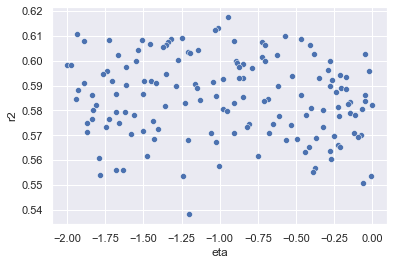

In [308]:
sns.scatterplot(np.log10(table_data['eta']),table_data['r2'])

<AxesSubplot:xlabel='eta', ylabel='epoch'>

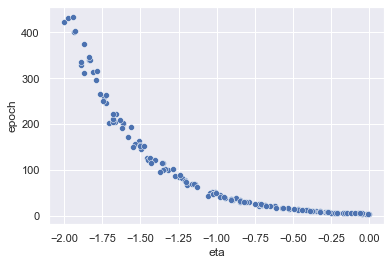

In [306]:
sns.scatterplot(np.log10(table_data['eta']),table_data['epoch'])

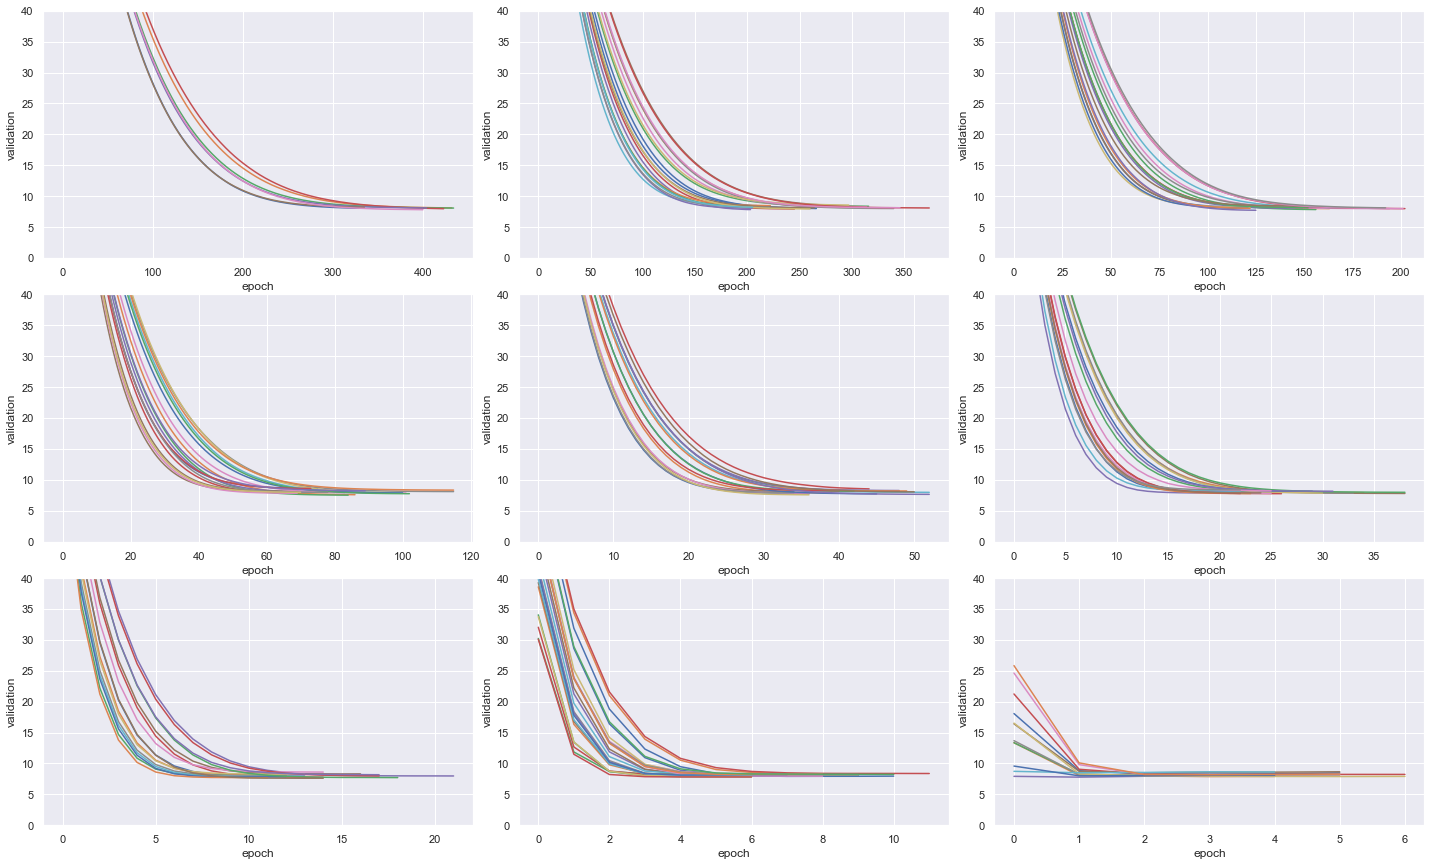

In [339]:
(d1,d2) = (3,3)
fig,axes = plt.subplots(d1, d2, figsize=(20,12))
fig.tight_layout()
fig_metrics = ['validation']
for i,j in enumerate(eta_groups):
    data = chart_data[chart_data['eta_group']==j]
    for p in set(data['permutation']):
        data2 = data[data['permutation']==p]
        s = sns.lineplot(ax=axes[i//3,i%3], x = data2['epoch'], y = data2['validation'])
        s.set_ylim(bottom=0, top=40);